# Extract a zonal area from the global llc 
# Save it to the netcdf llc.nc file


In [ ]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime

#import geopandas

import dask
#from dask.delayed import delayed

#from xmitgcm.llcreader import llcmodel as llc

%matplotlib inline
from matplotlib import pyplot as plt

from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile, Variable
from parcels import JITParticle, ScipyParticle
from parcels import ErrorCode, NestedField, AdvectionEE, AdvectionRK4

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.calval as ca

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
#    w = cluster.scale(jobs=13)
    w = cluster.scale(jobs=1)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.243:8787/status,
Dashboard: http://10.148.0.243:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.243:35876,Workers: 0
Dashboard: http://10.148.0.243:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
### Input parameters

In [3]:
# directories
root_dir = '/home1/datawork/slgentil/parcels/'
site = 'med_north'           # 'californie', 'med_north', 'med_south'
season = 'spring'             # 'spring', 'summer', 'autumn', 'winter'

---
### init parameters

In [4]:
# simulation parameters
T = 30. # length of the total run [days]
dt_window = timedelta(days=T) 
dt_step = timedelta(hours=1.) # time step [hour]

run_name = site+'_'+season

overwrite = True

bbox, lon_i, lat_i = ca.get_site_limits(site)
lonmin = bbox[0]
lonmax = bbox[1]
latmin = bbox[2]
latmax = bbox[3]
   
seasons={ 'spring':'2012-05-15T00:00', 
          'summer':'2012-08-15T00:00', 
          'autumn':'2011-11-15T00:00', 
          'winter':'2012-02-15T00:00' 
        }

## Methods

---

## load llc data

In [5]:
# load llc data
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])

/home1/datahome/slgentil/mit_equinox/mitequinox/utils.py:158: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(ref_data_dir + v + ".zarr")
/home1/datahome/slgentil/mit_equinox/mitequinox/utils.py:158: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Ex

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [6]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

In [7]:
create_tiles = True
#create_tiles = overwrite

if create_tiles:
    # create tiling
    _ds = grd.reset_coords().persist()
    tl = pa.tiler(ds=_ds, factor=(1, 1), overlap=(1, 1), 
                  global_llc=False, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

Tiler stored in /home1/datawork/slgentil/parcels/med_south_spring/tiling


In [8]:
tl.create_tile_run_tree(dirs["run"], overwrite=overwrite)

---

## create llc.nc netcdf file of the extracted zone


In [9]:
def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

In [10]:
# print step info
#t_start = ut.np64toDate(ds['time'][0].values)
t_start = ut.np64toDate(seasons[season])
t_end = t_start + dt_window + dt_step
format_info(0, t_start, t_end)
#tile=0
#step=0
    
# load, tile (and store) llc data
ds_tile = pa.tile_store_llc(ds,
                             slice(t_start, t_end, None),
                             tl,
                             netcdf=True,
                             global_llc=False,
                             lonmin=lonmin, lonmax=lonmax,
                             latmin=latmin, latmax=latmax
                            )


-------------------------------------------
step=0  /  start=2012-05-15:00  /  end=2012-06-14:01


/home1/datahome/slgentil/conda-env/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


---

## plot the extracted zone


<xarray.Dataset>
Dimensions:  (time: 722, j: 72, i: 48)
Coordinates: (12/19)
  * time     (time) datetime64[ns] 2012-05-15 ... 2012-06-14T01:00:00
    niter    (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) int64 10195 10196 10197 10198 10199 ... 10263 10264 10265 10266
  * i        (i) int64 1992 1993 1994 1995 1996 ... 2035 2036 2037 2038 2039
    XC       (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    ...       ...
    dxC      (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    dyC      (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    dxG      (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    dyG      (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    rAs      (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>
    rAw      (j, i) float32 dask.array<chunksize=(72, 48), meta=np.ndarray>

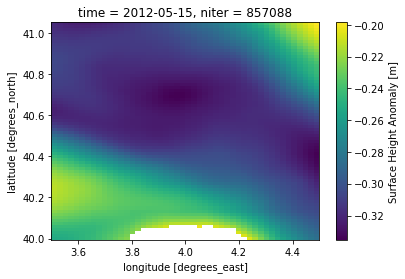

In [11]:
ds_tile = pa.load_ds_tile(tl)[0]
print(ds_tile)
ds_tile.Eta.isel(time=0).plot.pcolormesh(x='XC',y='YC')

In [12]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
